# 通し課題 Day1
## 目的
 課題①　KickStarter Project　
 https://www.kaggle.com/kemical/kickstarter-projects
 
 について分類アルゴリズムを実装評価する。
 

## 前準備
以下の処理を実行し、データの処理方針を決定する。

In [2]:
#各種必要ライブラリのロード
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [3]:
#データの読込
df = pd.read_csv("./ks-projects-201801.csv")

In [4]:
#データ概要の表示
df.tail()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.0
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.0
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.0
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.0
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.0,2011-07-19 09:07:47,524.0,failed,17,US,524.0,524.0,2000.0


- pledged , backer, usd pledged, usd pledged realについてはプロジェクト開始時には不明なデータであるため、処理対象から除外する


In [5]:
#Backers と　pleged　は入れてはならない
#箱ひげの方がわかりやすいかも

In [6]:
#開始時にはわからないデータを除去する
df = df.drop('pledged', axis=1)
df = df.drop('backers', axis=1)
df = df.drop('usd pledged', axis=1)
df = df.drop('usd_pledged_real', axis=1)

In [7]:
#処理後のデータを表示
df.tail()

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,canceled,US,50000.0
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,failed,US,1500.0
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,failed,US,15000.0
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,failed,US,15000.0
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.0,2011-07-19 09:07:47,failed,US,2000.0


以下の観点でデータ処理上の不都合がないかを確認する
- 全体のデータ数
- 欠損値の有無
- 目的変数が2値かどうか？
- カテゴリ変数がどの程度の種別数を持つか？

In [8]:
#データ数
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 11 columns):
ID               378661 non-null int64
name             378657 non-null object
category         378661 non-null object
main_category    378661 non-null object
currency         378661 non-null object
deadline         378661 non-null object
goal             378661 non-null float64
launched         378661 non-null object
state            378661 non-null object
country          378661 non-null object
usd_goal_real    378661 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 31.8+ MB


### データ情報についての考察
- 全データ数は378661件、目的変数stateをのぞき10個の説明変数がある
- non-nullであることから、欠損値はない
- ID/goal/usd_goal_real 以外はカテゴリ変数

データの概要をつかむため、各カテゴリ変数の種別数と頻度を求める

In [9]:
#データの概要をつかむため、各カテゴリ変数の種別数と頻度を求める
#各カテゴリ変数の種別数を求める
names = df.columns.values
for name in names:
    print('{} \t\t element num  = {}'.format(name, df[name].unique().size))

ID 		 element num  = 378661
name 		 element num  = 375765
category 		 element num  = 159
main_category 		 element num  = 15
currency 		 element num  = 14
deadline 		 element num  = 3164
goal 		 element num  = 8353
launched 		 element num  = 378089
state 		 element num  = 6
country 		 element num  = 23
usd_goal_real 		 element num  = 50339


- ID/name についてはほぼユニークな値が付いており、このままでは使えない
- categoryについては159もあるため、ダミー変数の列数が膨大になりそう。いったんはmain_categoryだけで分類を試みる。
- launched / deadlineについても日付をうまく処理し、簡易なカテゴリ変数に変換した方がよさそう



In [10]:
category_list = ['category', 'main_category', 'currency', 'state', 'country']
for cate in category_list:
    print('[', 'variable : ', cate, ']')
    for index, value in df[cate].value_counts().iteritems():
        print('\t', index, ': ', value)

[ variable :  category ]
	 Product Design :  22314
	 Documentary :  16139
	 Music :  15727
	 Tabletop Games :  14180
	 Shorts :  12357
	 Video Games :  11830
	 Food :  11493
	 Film & Video :  10108
	 Fiction :  9169
	 Fashion :  8554
	 Nonfiction :  8318
	 Art :  8253
	 Apparel :  7166
	 Theater :  7057
	 Technology :  6930
	 Rock :  6758
	 Children's Books :  6756
	 Apps :  6345
	 Publishing :  6018
	 Webseries :  5762
	 Photography :  5752
	 Indie Rock :  5657
	 Narrative Film :  5188
	 Web :  5153
	 Comics :  4996
	 Crafts :  4664
	 Country & Folk :  4451
	 Design :  4199
	 Hip-Hop :  3912
	 Hardware :  3663
	 Pop :  3350
	 Painting :  3294
	 Games :  3226
	 Illustration :  3175
	 Accessories :  3165
	 Public Art :  3077
	 Software :  3048
	 Gadgets :  2965
	 Restaurants :  2819
	 Mixed Media :  2757
	 Comic Books :  2743
	 Art Books :  2676
	 Classical Music :  2613
	 Animation :  2541
	 Playing Cards :  2497
	 Drinks :  2422
	 Dance :  2322
	 Comedy :  2320
	 Drama :  2179
	 Elect

In [11]:
#stateについてsuccesful及びfailed以外のデータを除去する
df_success = df[df['state'] == 'successful']
df_failed = df[df['state'] == 'failed']

df_input = pd.concat([df_success, df_failed])

for index, value in df_input['state'].value_counts().iteritems():
    print(index, ': ', value)

failed :  197719
successful :  133956


上記結果を比較し、正しくsuccessfulとfailedのみが抽出されたデータであることが確認できた

[ variable :  category ]
[ variable :  main_category ]
[ variable :  currency ]
[ variable :  country ]


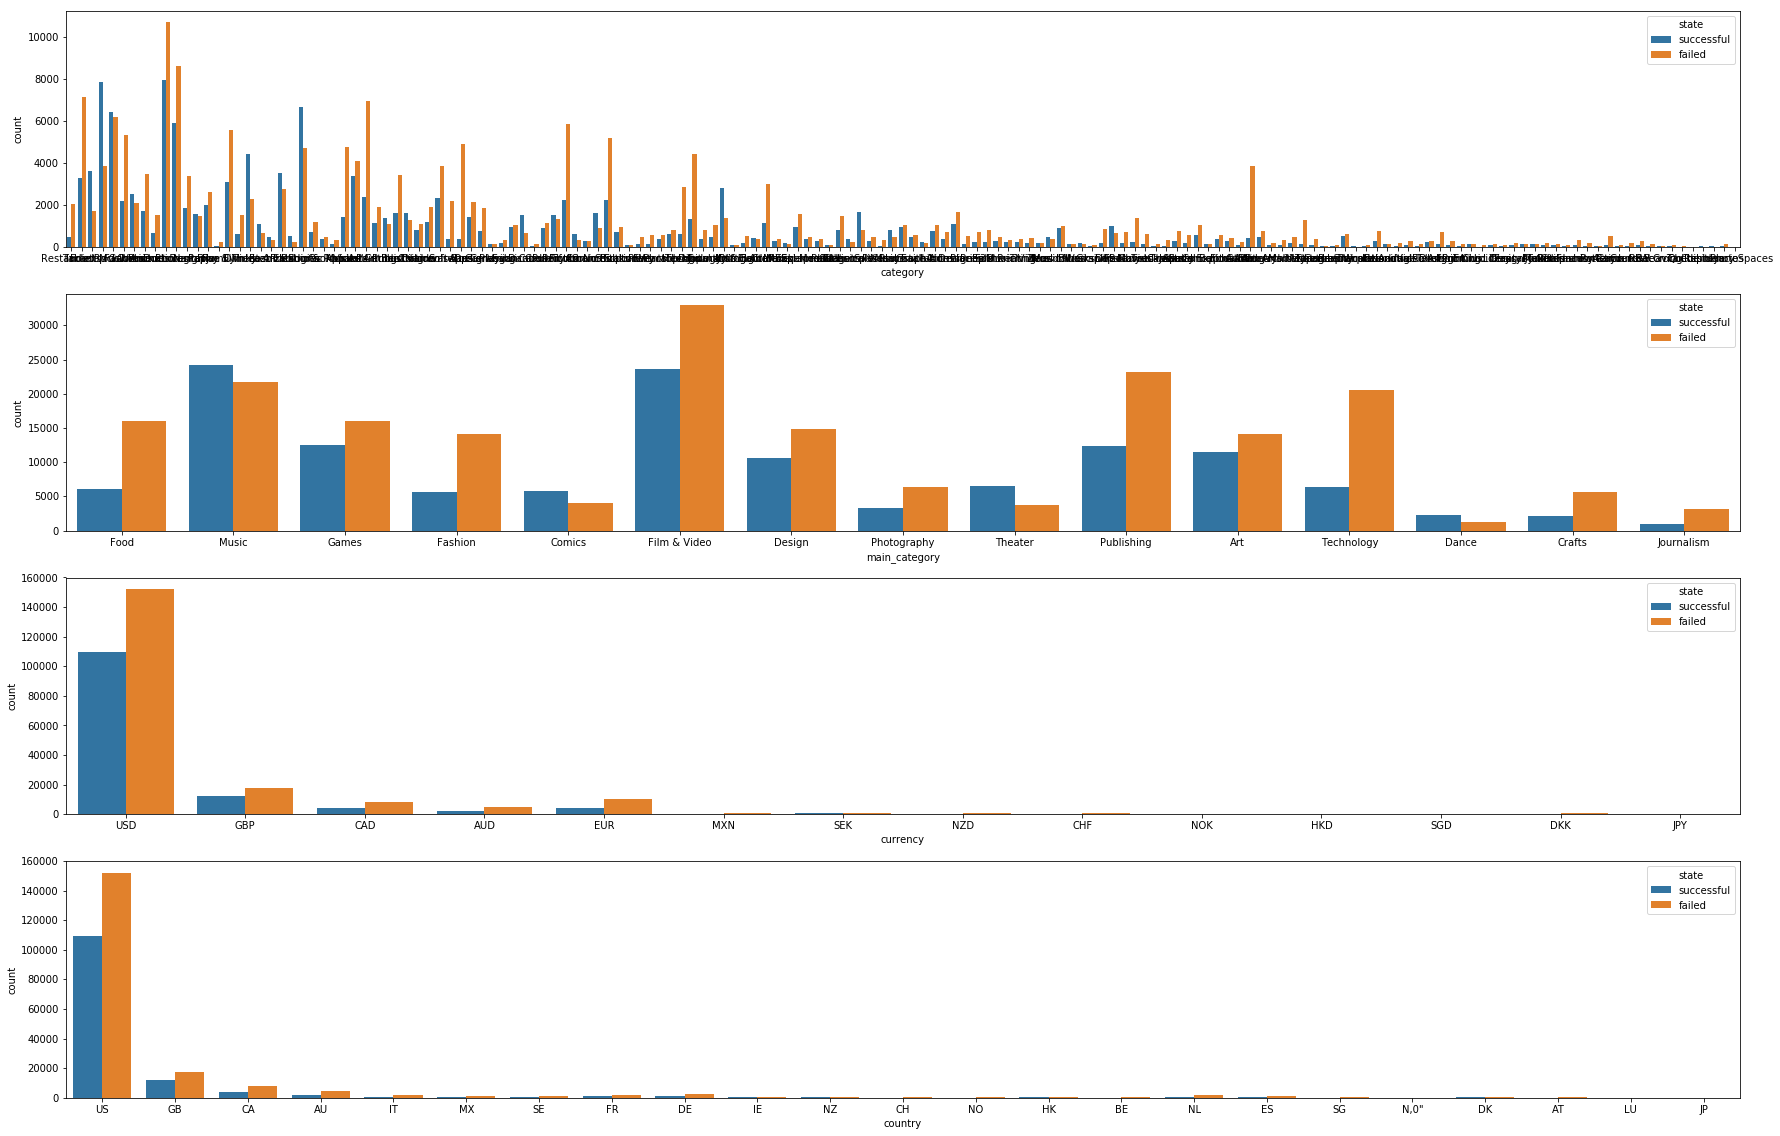

In [12]:
#各カテゴリごとにsuccess /failの分布をみてみる
category_list = ['category', 'main_category', 'currency', 'country']
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30,20))

ax_list = [ax1, ax2,  ax3, ax4]

for cate, axa in zip(category_list, ax_list):
    print('[', 'variable : ', cate, ']')
    sns.countplot(x=cate, data=df_input, hue='state', ax=axa)

- 一部のカテゴリで失敗しやすい/成功しやすいものがありそう
- メインカテゴリについて、food, fashion, film&video, publishing, technology系は失敗率が高そう。
- 逆に、Music, Theater,Danceは比較的成功率が高そう
- 通貨に依存して失敗/成功が決まることはなさそう
- 国によって失敗/成功がきまることはなさそう

- 各項目ごとの失敗成功の相対比を出してみてもよいかもしれない。

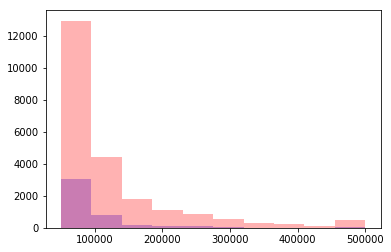

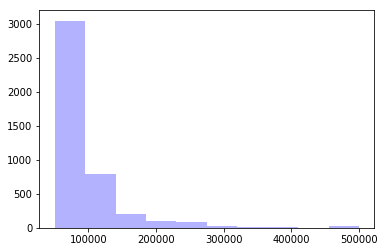

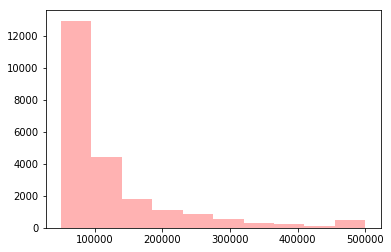

In [13]:
#usd_goal_realについても成功失敗でヒストグラムを出してみる
range_min = 0.05*1e6
range_max = 0.05*1e7
bin_num = 10

plt.figure()
plt.hist(df_success['usd_goal_real'], bins=bin_num, alpha=0.3, histtype='stepfilled', color='b', range=(range_min, range_max))
plt.hist(df_failed['usd_goal_real'], bins=bin_num, alpha=0.3, histtype='stepfilled', color='r', range=(range_min, range_max))
plt.show()

plt.hist(df_success['usd_goal_real'], bins=bin_num, alpha=0.3, histtype='stepfilled', color='b', range=(range_min, range_max))
plt.show()

plt.hist(df_failed['usd_goal_real'], bins=bin_num, alpha=0.3, histtype='stepfilled', color='r', range=(range_min, range_max))
plt.show()

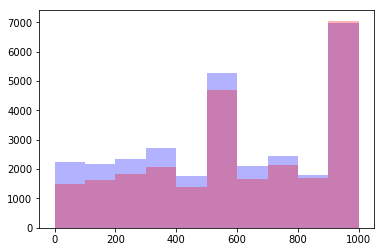

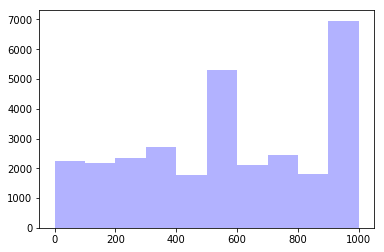

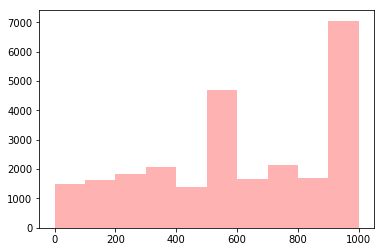

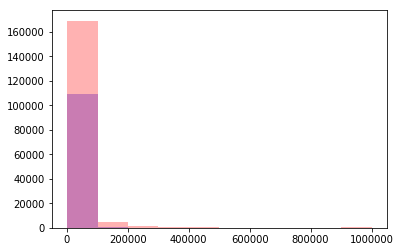

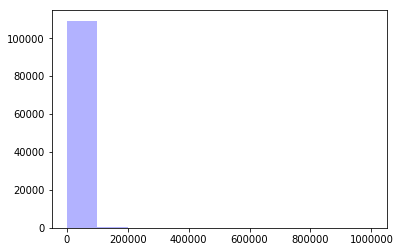

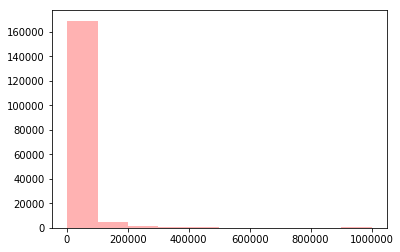

In [14]:
#usd_goal_realについても成功失敗でヒストグラムを出してみる
range_min = 0.0
range_max = 1e3
bin_num = 10

for range_min, range_max in zip([0.0, 1e3], [1e3, 1e6]):

    plt.figure()
    plt.hist(df_success['usd_goal_real'], bins=bin_num, alpha=0.3, histtype='stepfilled', color='b', range=(range_min, range_max))
    plt.hist(df_failed['usd_goal_real'], bins=bin_num, alpha=0.3, histtype='stepfilled', color='r', range=(range_min, range_max))
    plt.show()

    plt.hist(df_success['usd_goal_real'], bins=bin_num, alpha=0.3, histtype='stepfilled', color='b', range=(range_min, range_max))
    plt.show()

    plt.hist(df_failed['usd_goal_real'], bins=bin_num, alpha=0.3, histtype='stepfilled', color='r', range=(range_min, range_max))
    plt.show()

### usd_goal_realの考察
- 額が大きくなるほど失敗の可能性が上がっている


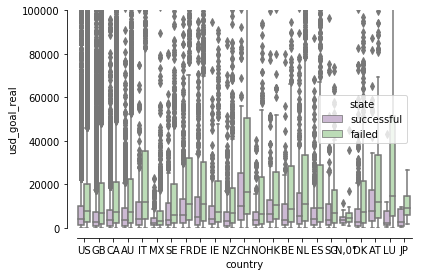

In [15]:
#usd_goal_realと国について箱ひげ図を書いてみる
plt.ylim(0.0, 1e5)
sns.boxplot(x='country', y="usd_goal_real", hue='state', data=df_input, palette="PRGn")
sns.despine(offset=10, trim=False)

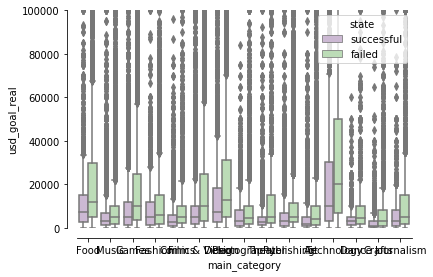

In [16]:
#usd_goal_realと国について箱ひげ図を書いてみる
plt.ylim(0.0, 1e5)
sns.boxplot(x='main_category', y="usd_goal_real", hue='state', data=df_input, palette="PRGn")
sns.despine(offset=10, trim=False)

### 箱ひげ図の考察
- 国に関係なく、額が低い方が成功しやすく、高い方が失敗しやすいといえそう。
- 特定のジャンルにおいては特に金額と成否に関係がないものもありそう

In [17]:
#日付についても

次にカテゴリ変数のdummy変数化を行う。

In [18]:
df_input = pd.concat([df_input, pd.get_dummies(df_input['main_category'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['currency'])], axis=1)
df_input = pd.concat([df_input, pd.get_dummies(df_input['country'])], axis=1)
df_input.tail()

,ID,name,category,main_category,currency,deadline,goal,launched,state,country,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
378654,999975836,"Homemade fresh dog food, Cleveland OH",Small Batch,Food,USD,2017-04-19,6500.0,2017-03-20 22:08:22,failed,US,...,0,0,0,0,0,0,0,0,0,1
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,failed,US,...,0,0,0,0,0,0,0,0,0,1
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,failed,US,...,0,0,0,0,0,0,0,0,0,1
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,failed,US,...,0,0,0,0,0,0,0,0,0,1
378660,999988282,Nou Renmen Ayiti! We Love Haiti!,Performance Art,Art,USD,2011-08-16,2000.0,2011-07-19 09:07:47,failed,US,...,0,0,0,0,0,0,0,0,0,1


特徴量が63次元になった。
若干多すぎると思われるが、現状はこのまま進めてみる。

### 疑問点
- 63次元になると散布図行列の計算がまともにできない　→　何かうまい方法がないか？
- カテゴリ変数同士の関係はどうみればよいか？

#### 判定アルゴリズムの実装
ロジスティック回帰モデルを用いて判定を行う。

In [28]:
y = df_input["state"] == 'successful'
X = df_input.drop(['state','ID', 'name','category','deadline','launched', 'main_category', 'currency', 'country'], axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

#1 iterationあたり100msecくらい？
#いろいろためすのでいったん1000くらいにしておく？


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [24]:
y_est = clf.predict(X)

In [33]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -15.977
正答率 = 53.744%


In [34]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
conf_mat

,予測 = successful,予測 = failed
正解 = successful,64801,132918
正解 = failed,20502,113454


単純にiterationが足りていないか、データの作り方がまずかったのか検証が必要